In [9]:
import astropy.io.fits as fits
import des_functions
import treecorr
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from more_itertools import locate
os.chdir('/home/b7009348/projects/WGL_Project')

# Response Matrix
- R11 ~ R22 
- R12 ~ R21 ~ 0
- So just take mean of R11 or R22 for \<R>

In [2]:
with fits.open('DES-data/y1_mcal_shapes_matched.fits') as hdu:
    data = hdu[1].data
    R11 = data['R11'] # e1-e1
del data
R = np.mean(R11)
print(R)

0.7130916429874178


In [7]:
0.0098/R * 100

1.3742974127342167

# Selection Response

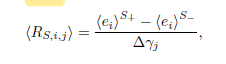

In [6]:
Image.open('des-y1-matched-catalogue/selection_response_eqn.png')

- Need to measure response of estimator to the selection
- Ellipticity distribution is approximately unchanged so might be able to ignore selection response?

# Comparing IM3 and MCAL Tangential Shear 
(count-shear correlation + response correction)

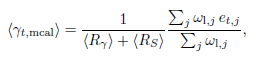

In [23]:
Image.open('des-y1-matched-catalogue/mcal_gammat_eqn.png')

Ry and Rs have no significant variation with $\theta$ so can use constant value

In [4]:
with fits.open('DES-data/DES_Y1A1_3x2pt_redMaGiC_zerr_CATALOG.fits') as hdu:
    data = hdu[1].data
    ra_l = data['RA']
    dec_l = data['DEC']
    w_l = data['weight']
    
del data
    
cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units='deg', dec_units='deg', w=w_l, npatch=20)

with fits.open('DES-data/DES_Y1A1_3x2pt_redMaGiC_RANDOMS.fits') as hdu:
    data = hdu[1].data
    ra_r = data['RA']
    dec_r = data['dec']
    
del data
    
cat_r = treecorr.Catalog(ra=ra_r, dec=dec_r, ra_units='deg', dec_units='deg', patch_centers=cat_l.patch_centers)

with fits.open('DES-data/y1_mcal_shapes_matched.fits') as hdu:
    data = hdu[1].data
    ra_s = data['ra']
    dec_s = data['dec']
    e1_m = data['e1']
    e2_m = data['e2']
    
del data

cat_s_mcal = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', g1=e1_m, g2=e2_m, patch_centers=cat_l.patch_centers)

print('Catalogues created, starting correlation calculation...')

nbins=20
theta_min=2.5
theta_max=250

mcal_ng = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin', var_method='jackknife')
mcal_ng.process(cat_l, cat_s_mcal)

mcal_rg = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
mcal_rg.process(cat_r, cat_s_mcal)

print('mcal correlation calculation complete.')
    
del cat_s_mcal
    
mcal_xi_l = mcal_ng.xi
mcal_xi_r = mcal_rg.xi

mcal_Gammat = 1.0/np.mean(R) * (mcal_xi_l - mcal_xi_r)

mcal_theta = np.exp(mcal_ng.meanlogr)

del e1_m, e2_m, R

Catalogues created, starting correlation calculation...
mcal correlation calculation complete.


In [5]:
with fits.open('DES-data/y1_im3_shapes_matched.fits') as hdu:
    data = hdu[1].data
    ra_s = data['ra']
    dec_s = data['dec']
    e1 = data['e1'] - data['c1']
    e2 = data['e2'] - data['c2']
    sens = data['m'] + 1.0
    w = data['weight']
    
del data
 
cat_s = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', g1=e1, g2=e2, w=w, patch_centers=cat_l.patch_centers)
cat_k = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', k=sens, w=w, patch_centers=cat_l.patch_centers)
    
# do correlations with lenese, NKCorrelation is used to apply multiplicative correction
im3_ng = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin', var_method='jackknife')
im3_ng.process(cat_l, cat_s)
nk = treecorr.NKCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
nk.process(cat_l, cat_k)
    
# do correlations with randoms
im3_rg = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin', var_method='jackknife')
im3_rg.process(cat_r, cat_s)
rk = treecorr.NKCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
rk.process(cat_r, cat_k)
    
# correlation functions and corrections for lenses and randoms
im3_xi_l = im3_ng.xi
sens_l = nk.xi
im3_xi_r = im3_rg.xi
sens_r = rk.xi
    
# store data in preallocated arrays
im3_Gammat = im3_xi_l/sens_l - im3_xi_r/sens_r
im3_theta = np.exp(im3_ng.meanlogr)

del e1, e2, sens, w

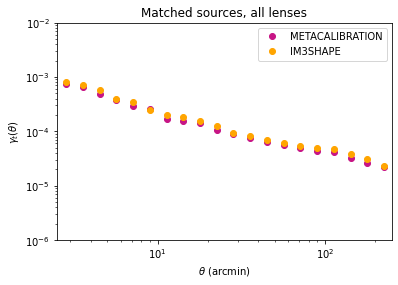

In [6]:
plt.plot(mcal_theta, mcal_Gammat, linewidth=0, marker='o', color='mediumvioletred')
plt.plot(im3_theta, im3_Gammat, linewidth=0, marker='o', color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ (arcmin)')
plt.ylabel(r'$\gamma_{t}(\theta)$')
plt.title('Matched sources, all lenses')
plt.ylim([1e-6, 1e-2])
plt.xlim([2.5,250])
plt.legend(['METACALIBRATION', 'IM3SHAPE'])
plt.savefig('des-y1-matched-catalogue/matched-sources_all-lenses.png', dpi=300)

In [10]:
ratio = im3_Gammat/mcal_Gammat
perc = (ratio-1.0)*100
print(perc)

[ 7.87753581  8.92555684 22.07677307  3.3841035  16.915394   -1.61535845
 18.76794596 21.69206735 11.04767833 20.43210305  6.16651064  6.65729551
  8.44473822 10.1677514   7.6466458  10.70287157 14.0850423  17.78433082
 18.20422895  1.40624719]


In [9]:
mcal_Gammat - im3_Gammat

array([-5.83268041e-05, -5.78668110e-05, -1.05974685e-04, -1.29677766e-05,
       -4.98993470e-05,  4.11074606e-06, -3.09296175e-05, -3.28305375e-05,
       -1.56082436e-05, -2.16373865e-05, -5.48746627e-06, -5.05902545e-06,
       -5.40312926e-06, -5.73341290e-06, -3.80888373e-06, -4.69134936e-06,
       -5.76829392e-06, -5.81383778e-06, -4.82213056e-06, -3.14983124e-07])

# Recreating Prat et al. 2018 MCAL plots

In [27]:
zmins = [0.2,0.43,0.63,0.9]
zmaxs = [0.43,0.63,0.9,1.3]

for i in range(len(zmins)):
    des_functions.cut_redshift(shapefile='y1_mcal_flags=0.fits', zfile='y1a1-gold-mof-badregion_BPZ.fits',
                              zmin=zmins[i], zmax=zmaxs[i], method='mcal')

Opening files...
Locating sources in range 0.2 - 0.43...
Sources in range found, slicing data...
Matching redshifts to catalogue...
Slicing catalogue data...
Data sliced, writing to new file...
Runtime: 1483.61
Opening files...
Locating sources in range 0.43 - 0.63...
Sources in range found, slicing data...
Matching redshifts to catalogue...
Slicing catalogue data...
Data sliced, writing to new file...
Runtime: 1044.52
Opening files...
Locating sources in range 0.63 - 0.9...
Sources in range found, slicing data...
Matching redshifts to catalogue...
Slicing catalogue data...
Data sliced, writing to new file...
Runtime: 931.796
Opening files...
Locating sources in range 0.9 - 1.3...
Sources in range found, slicing data...
Matching redshifts to catalogue...
Slicing catalogue data...
Data sliced, writing to new file...
Runtime: 291.655


In [36]:
data_dir = 'DES-data/'

# read in lens data and create treecorr catalogue object to store
with fits.open(data_dir+'DES_Y1A1_Lenses_z=0.15-0.3.fits') as hdu:
    data = hdu[1].data
    ra_l = data['RA']
    dec_l = data['DEC']
    w_l = data['weight']
    
cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units='deg', dec_units='deg', w=w_l, npatch=20)

# read in randoms data and create treecorr catalogue
with fits.open(data_dir+'DES_Y1A1_3x2pt_redMaGiC_RANDOMS.fits') as hdu:
    data = hdu[1].data
    indexes = list(locate(data['z'], lambda x: 0.15 < x < 0.3)) # cut randoms to same redshift as lenses 
    ra_r = data['RA'][indexes]
    dec_r = data['dec'][indexes]
    
cat_r = treecorr.Catalog(ra=ra_r, dec=dec_r, ra_units='deg', dec_units='deg', patch_centers=cat_l.patch_centers)

# delte data to free memory
del indexes, data

# define bin and scale params
nbins=20
theta_min=2.5
theta_max=250

nlens = float(len(ra_l)) # number of lenses
nrand = float(len(ra_r)) # number of randoms

# list of source files to compute cross-correlation for 
source_files = ['y1_mcal_z=0.9-1.3.fits', 'y1_mcal_z=0.63-0.9.fits', 'y1_mcal_z=0.43-0.63.fits', 'y1_mcal_z=0.2-0.43.fits']
Rs = [0.014, 0.0098, 0.014, 0.0072]

# empty arrays to store correlation function data 
Gammat = np.zeros([nbins,len(source_files)])
sig = np.zeros([nbins,len(source_files)])
theta = np.zeros([nbins,len(source_files)])
Boost = np.zeros_like(Gammat)
theta_b = np.zeros_like(Gammat)

# loops over source files and computes cross-correltaion for different source redshift samples
for i in range(len(source_files)):
    with fits.open(data_dir+source_files[i]) as hdu:
        data = hdu[1].data
        ra_s = data['ra']
        dec_s = data['dec']
        e1 = data['e1']
        e2 = data['e2']
        R = np.mean(data['R11'])
    del data
 
    cat_s = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', g1=e1, g2=e2, patch_centers=cat_l.patch_centers)
    
    # do correlations with lenese, NKCorrelation is used to apply multiplicative correction
    ng = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin', var_method='jackknife')
    ng.process(cat_l, cat_s)
    
    # do correlations with randoms
    rg = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin', var_method='jackknife')
    rg.process(cat_r, cat_s)
    
    # correlation functions and corrections for lenses and randoms
    xi_l = ng.xi
    xi_r = rg.xi
    
    # store data in preallocated arrays
    Gammat[:,i] = 1.0/(R+Rs[i]) * (xi_l - xi_r)
    theta[:,i] = np.exp(ng.meanlogr)
    
    # all errors
    l_err = np.sqrt(ng.varxi) # error on lens-shear cross-corr
    r_err = np.sqrt(rg.varxi) # error on random-shear cross-corr
    
    # next do errors for subtraction of randoms to get error on gamma_t
    sig[:,i] = np.sqrt(l_err**2 + r_err**2)
    
    perc = Rs[i]/R * 100.0
    print(perc)

2.5406275758772914
1.5924190864449301
2.269215786803211
0.9666339423765827


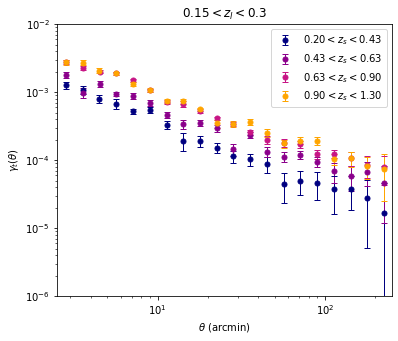

In [37]:
plt.figure(figsize=[6,5])
plt.errorbar(theta[:,3], Gammat[:,3], yerr=sig[:,3], lw=0, marker='o', color='navy', markersize=5, elinewidth=1, capsize=3)
plt.errorbar(theta[:,2], Gammat[:,2], yerr=sig[:,2], lw=0, marker='o', color='darkmagenta', markersize=5, elinewidth=1, capsize=3)
plt.errorbar(theta[:,1], Gammat[:,1], yerr=sig[:,1], lw=0, marker='o', color='mediumvioletred', markersize=5, elinewidth=1, capsize=3)
plt.errorbar(theta[:,0], Gammat[:,0], yerr=sig[:,0], lw=0, marker='o', color='orange', markersize=5, elinewidth=1, capsize=3)
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-6, 1e-2])
plt.xlim([2.5,250])
plt.xlabel(r'$\theta$ (arcmin)')
plt.ylabel(r'$\gamma_{t}(\theta)$')
plt.legend([r'$0.20<z_{s}<0.43$', r'$0.43<z_{s}<0.63$', r'$0.63<z_{s}<0.90$', r'$0.90<z_{s}<1.30$'])
plt.title(r'$0.15<z_{l}<0.3$')
plt.savefig('des-y1-matched-catalogue/mcal_zl=0.15-0.3.png', dpi=300)

In [45]:
data_dir = 'DES-data/'

# read in lens data and create treecorr catalogue object to store
with fits.open(data_dir+'DES_Y1A1_Lenses_z=0.3-0.45.fits') as hdu:
    data = hdu[1].data
    ra_l = data['RA']
    dec_l = data['DEC']
    w_l = data['weight']
    
cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units='deg', dec_units='deg', w=w_l, npatch=20)

# read in randoms data and create treecorr catalogue
with fits.open(data_dir+'DES_Y1A1_3x2pt_redMaGiC_RANDOMS.fits') as hdu:
    data = hdu[1].data
    indexes = list(locate(data['z'], lambda x: 0.15 < x < 0.3)) # cut randoms to same redshift as lenses 
    ra_r = data['RA'][indexes]
    dec_r = data['dec'][indexes]
    
cat_r = treecorr.Catalog(ra=ra_r, dec=dec_r, ra_units='deg', dec_units='deg', patch_centers=cat_l.patch_centers)

# delte data to free memory
del indexes, data

# define bin and scale params
nbins=20
theta_min=2.5
theta_max=250

nlens = float(len(ra_l)) # number of lenses
nrand = float(len(ra_r)) # number of randoms

# list of source files to compute cross-correlation for 
source_files = ['y1_mcal_z=0.9-1.3.fits', 'y1_mcal_matched_z=0.9-1.3.fits']
Rs = 0.014

# empty arrays to store correlation function data 
Gammat = np.zeros([nbins,len(source_files)])
sig = np.zeros([nbins,len(source_files)])
theta = np.zeros([nbins,len(source_files)])
Boost = np.zeros_like(Gammat)
theta_b = np.zeros_like(Gammat)

# loops over source files and computes cross-correltaion for different source redshift samples
for i in range(len(source_files)):
    with fits.open(data_dir+source_files[i]) as hdu:
        data = hdu[1].data
        ra_s = data['ra']
        dec_s = data['dec']
        e1 = data['e1']
        e2 = data['e2']
        R = np.mean(data['R11'])
    del data
 
    cat_s = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', g1=e1, g2=e2, patch_centers=cat_l.patch_centers)
    
    # do correlations with lenese, NKCorrelation is used to apply multiplicative correction
    ng = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin', var_method='jackknife')
    ng.process(cat_l, cat_s)
    
    # do correlations with randoms
    rg = treecorr.NGCorrelation(nbins=nbins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin', var_method='jackknife')
    rg.process(cat_r, cat_s)
    
    # correlation functions and corrections for lenses and randoms
    xi_l = ng.xi
    xi_r = rg.xi
    
    # store data in preallocated arrays
    Gammat[:,i] = 1.0/(R+Rs) * (xi_l - xi_r)
    theta[:,i] = np.exp(ng.meanlogr)
    
    # all errors
    l_err = np.sqrt(ng.varxi) # error on lens-shear cross-corr
    r_err = np.sqrt(rg.varxi) # error on random-shear cross-corr
    
    # next do errors for subtraction of randoms to get error on gamma_t
    sig[:,i] = np.sqrt(l_err**2 + r_err**2)
    
    perc = Rs/R * 100.0
    print(perc)

2.5406275758772914
2.1153258379373634


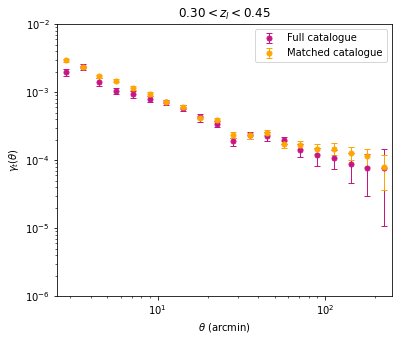

In [46]:
plt.figure(figsize=[6,5])
plt.errorbar(theta[:,1], Gammat[:,1], yerr=sig[:,1], lw=0, marker='o', color='mediumvioletred', markersize=5, elinewidth=1, capsize=3)
plt.errorbar(theta[:,0], Gammat[:,0], yerr=sig[:,0], lw=0, marker='o', color='orange', markersize=5, elinewidth=1, capsize=3)
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-6, 1e-2])
plt.xlim([2.5,250])
plt.xlabel(r'$\theta$ (arcmin)')
plt.ylabel(r'$\gamma_{t}(\theta)$')
plt.legend(['Matched catalogue', 'Full catalogue'])
plt.title(r'$0.30<z_{l}<0.45$')
plt.savefig('des-y1-matched-catalogue/mcal_comparison_zs=0.3-0.45_zl=0.9-1.3.png', dpi=300)